In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pysindy as ps
import pde # If give us problem we have to put on requirement.txt numpy older version

In [ ]:
data = pd.read_csv('Data/Simulations/Harmonic_w1.csv')

In [ ]:

u = data.iloc[:, 1:].to_numpy()
u = u.astype('complex128')

Nx = 512                   # number of points -1
x = np.linspace(-7.5, 7.5, Nx)  # spatial grid points
dx = x[1]-x[0]              # spatial separation

Nt = 400                 # time interval for snapshots
t0 = 0.0                    # initial time
tf = 10                     # final time
t = np.linspace(t0, tf, Nt)
dt = t[1]-t[0]

dt = t[1] - t[0]
dx = x[1] - x[0]


u_dot = ps.FiniteDifference(axis=0)._differentiate(u, t=dt)

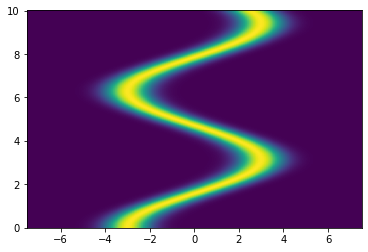

In [ ]:
plt.pcolormesh(x,t, np.abs(u)**2)

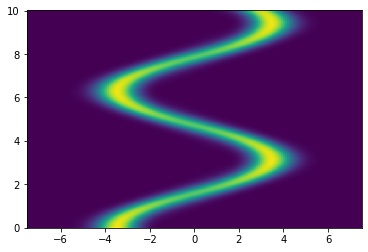

In [ ]:
plt.pcolormesh(x, t, np.abs(u_dot)**2)

In [ ]:
u_real = np.real(u)
u_img = np.imag(u)

u_dot_real = np.real(u_dot)
u_dot_img = np.imag(u_dot)

u_shaped = np.zeros(shape=(len(x), len(t), 3))
u_shaped[:,:, 0]=u_real.T
u_shaped[:,:, 1]=u_img.T
u_shaped[:,:, 2]=np.tile(x,(len(t),1)).T # add x values to pass to u and u_dot (in these way one can introduce spatial potential terms)

u_dot_shaped = np.zeros(shape=(len(x), len(t), 2))
u_dot_shaped[:,:, 0]=u_dot_real.T
u_dot_shaped[:,:, 1]=u_dot_img.T

In [ ]:
poly_library = ps.PolynomialLibrary(include_bias=False)

x_lib_function = [lambda x: np.arctan(x), lambda x: np.exp(x**2/2)]
x_lib_function_names = [lambda x: f'arctan({x})', lambda x: f'exp({x}^2/2)']

x_library=ps.CustomLibrary(library_functions=x_lib_function,
                          function_names=x_lib_function_names,
                          include_bias=False)
                          
# x_library = ps.SINDyPILibrary(
#     library_functions=x_lib_function,
#     function_names=x_lib_function_names,
#     include_bias=True,
# )

library_functions = [lambda x: x]
library_function_names = [lambda x:x]
pde_library = ps.PDELibrary(library_functions=library_functions, 
                        function_names=library_function_names, 
                        derivative_order=2, spatial_grid=x, 
                        include_bias=True, is_uniform=True, include_interaction=False)


# Tensor polynomial library with the PDE library
tensor_array = [[1, 1]]

inputs_temp = np.tile([0, 1, 2], 2)
inputs_per_library = np.reshape(inputs_temp, (2, 3))
inputs_per_library[1,2] = 0 # only compute PDs for psi_real and psi_img
inputs_per_library[0] = [2, 2, 2] # only compute polynomial for x input feature


# Fit a generalized library of 3 feature libraries + 1 internally 
# generated tensored library and only use the input variable phi 
# for the PDELibrary. Note that this holds true both for the 
# individual PDELibrary and any tensored libraries constructed from it.
generalized_library = ps.GeneralizedLibrary(
    [poly_library+x_library, pde_library],
    tensor_array=tensor_array,
    inputs_per_library=inputs_per_library,
)


optimizer = ps.STLSQ(threshold=0.1)
model = ps.SINDy(feature_library=generalized_library, optimizer=optimizer, feature_names=['psi_r', 'psi_i', 'x'])
model.fit(u_shaped, x_dot=u_dot_shaped)
model.print()

print(generalized_library.get_feature_names(), "\n")

C:\Users\loren\anaconda3\envs\sindy\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.20803e-29): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


(psi_r)' = -0.497 psi_i_11 + 0.497 x^2 psi_i
(psi_i)' = 0.497 psi_r_11 + -0.498 x^2 psi_r
['x2', 'x2^2', 'arctan(x2)', 'exp(x2^2/2)', '1', 'x0', 'x1', 'x0_1', 'x1_1', 'x0_11', 'x1_11', 'x2 1', 'x2 x0', 'x2 x1', 'x2 x0_1', 'x2 x1_1', 'x2 x0_11', 'x2 x1_11', 'x2^2 1', 'x2^2 x0', 'x2^2 x1', 'x2^2 x0_1', 'x2^2 x1_1', 'x2^2 x0_11', 'x2^2 x1_11', 'arctan(x2) 1', 'arctan(x2) x0', 'arctan(x2) x1', 'arctan(x2) x0_1', 'arctan(x2) x1_1', 'arctan(x2) x0_11', 'arctan(x2) x1_11', 'exp(x2^2/2) 1', 'exp(x2^2/2) x0', 'exp(x2^2/2) x1', 'exp(x2^2/2) x0_1', 'exp(x2^2/2) x1_1', 'exp(x2^2/2) x0_11', 'exp(x2^2/2) x1_11'] 



C:\Users\loren\anaconda3\envs\sindy\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.20803e-29): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


In [ ]:
inputs_per_library

array([[0, 1, 2],
       [0, 1, 2],
       [0, 1, 2]])

In [ ]:
model.coefficients()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
uxx_re = model.coefficients()[0,8]
uxx_im = model.coefficients()[1,7]
x2psi_re = model.coefficients()[0,18]
x2psi_im = model.coefficients()[1,17]


In [ ]:
Eq = pde.PDE({'psi_r':'{}*laplace(psi_i)+{}*x*x*psi_i'.format(uxx_re, x2psi_re), 
              'psi_i':'{}*laplace(psi_r)+{}*x*x*psi_r'.format(uxx_im, x2psi_im)})


In [ ]:
u_shaped[:,0,:-1].shape

(512, 2)

In [ ]:
Eq.

In [ ]:
grid = pde.CartesianGrid([(x[0], x[-1])], [Nx], False)  # generate grid

# create a (normalized) wave packet with a certain form as an initial condition
initial_state_r = pde.ScalarField(grid, u_real[0])
initial_state_i = pde.ScalarField(grid, u_img[0])

initial_state = pde.FieldCollection([initial_state_r, initial_state_i])

array([[ 2.96002470e-05,  3.51707653e-05,  3.81769279e-05, ...,
        -7.79404773e-09,  9.16518127e-09, -6.06328887e-09],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [ ]:
storage = pde.MemoryStorage()
result = Eq.solve(initial_state, t_range=10, dt=dt, tracker=[storage.tracker(0.02)])

# visualize the results as a space-time plot
pde.plot_kymographs(storage, scalar="norm_squared")

/root/venv/lib/python3.8/site-packages/pde/fields/scalar.py:406: RuntimeWarning: overflow encountered in multiply
  data = self.data * self.data.conjugate()
/shared-libs/python3.8/py/lib/python3.8/site-packages/matplotlib/colorbar.py:1147: RuntimeWarning: overflow encountered in add
  self._values = 0.5 * (self._boundaries[:-1] + self._boundaries[1:])


OverflowError: cannot convert float infinity to integer

<Figure size 576x216 with 4 Axes>

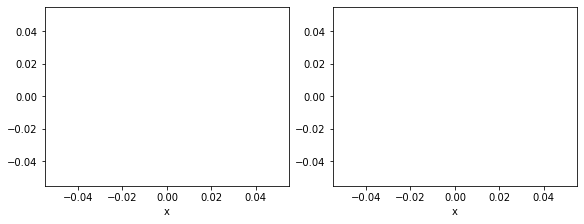

In [ ]:
result.plot()

ScalarField(grid=CartesianGrid(bounds=((-7.5, 7.5),), shape=(512,), periodic=[False]), data=[ 2.96002470e-05  3.51707653e-05  3.81769279e-05  4.53600686e-05
  5.02149686e-05  5.77257232e-05  6.56698431e-05  7.39189776e-05
  8.45593012e-05  9.52483695e-05  1.07970836e-04  1.22338701e-04
  1.37781986e-04  1.56002800e-04  1.75730051e-04  1.98013419e-04
  2.23252409e-04  2.50825933e-04  2.82231259e-04  3.16924408e-04
  3.55509809e-04  3.98879089e-04  4.46589734e-04  5.00004511e-04
  5.59217435e-04  6.24669093e-04  6.97623407e-04  7.77994864e-04
  8.67101321e-04  9.65654984e-04  1.07416755e-03  1.19424150e-03
  1.32630506e-03  1.47175864e-03  1.63194799e-03  1.80768052e-03
  2.00092585e-03  2.21277138e-03  2.44486448e-03  2.69922667e-03
  2.97718132e-03  3.28114385e-03  3.61299712e-03  3.97482637e-03
  4.36939216e-03  4.79874334e-03  5.26585509e-03  5.77352779e-03
  6.32448349e-03  6.92229475e-03  7.56991921e-03  8.27101887e-03
  9.02940615e-03  9.84861975e-03  1.07331062e-02  1.16868653e-0

In [ ]:
.shape

(2000,)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=964d390d-0269-41ab-86ee-4ee3752d1778' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>